# Black box (?)
by: Santiago Hincapie-Potes

### MNIST
a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau

In [15]:
%time
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.7 µs


/home/sivico26/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/sivico26/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


HTTPError: HTTP Error 500: Internal Server Error

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape, 28*28)
print(y.shape)

(70000, 784) 784
(70000,)


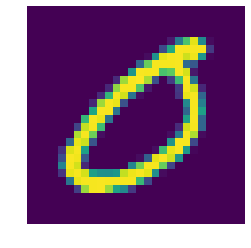

0.0


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

some_digit = X[420]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, interpolation="nearest")
plt.axis("off")

plt.show()
print(y[420])

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

Shuffling may be a bad idea in some context

In [5]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

In [6]:
# "0-detector"
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=100)
sgd_clf.fit(X_train, y_train_0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures
Evaluating a classifier is often significantly tricky

### K-fold Cross-validation
splitting the training set into K-folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.98890055, 0.987     , 0.98849942])

jmmmm $\sim98\%$ looks amazing, doesn't it?

In [10]:
from sklearn.base import BaseEstimator

class Never0Classifier(BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)

Can you guess this model’s accuracy?

In [11]:
bad = Never0Classifier()

cross_val_score(bad, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.9001 , 0.90065, 0.9031 ])

### Confusion Matrix
Count the number of times instances of class A are
classified as class B.

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_0, y_train_pred, labels=[True, False])

array([[ 5549,   374],
       [  338, 53739]])

In [14]:
well = y_train_0 == y_train_pred
print(np.sum(well & y_train_0), np.sum(~well & y_train_0))
print(np.sum(~well & ~y_train_0), np.sum(well & ~y_train_0))

5549 374
338 53739


![](https://cdn-images-1.medium.com/max/800/1*g5zpskPaxO8uSl0OWT4NTQ.png)

### Precision/Recall

$$\text{precision} = \frac{TP}{TP + FP}$$


$$\text{recall} = \frac{TP}{TP + FN}$$

In [15]:
from sklearn.metrics import precision_score, recall_score
cm = confusion_matrix(y_train_0, y_train_pred, labels=[True, False])

print(cm[0,0]/np.sum(cm[:,0]), precision_score(y_train_0, y_train_pred))
print(cm[0,0]/np.sum(cm[0,:]), recall_score(y_train_0, y_train_pred))

0.9425853575675217 0.9425853575675217
0.9368563228093871 0.9368563228093871


$$ F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} $$

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_0, y_train_pred)

0.9397121083827265

# Machine learning workflow

* Define model pattern
* Define cost function
* Optimize
* Evaluate

In [17]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

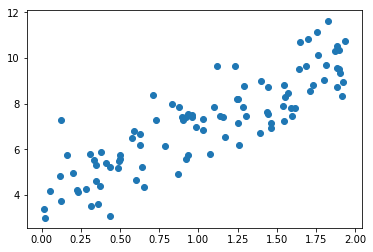

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X, y);

### Linear Regression
$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n $$
where
* $\hat{y}$ is the predicted value
* $n$ is the number of features
* $x_i$ is the i$^\text{th}$ feature
* $x_j$ is the j$^\text{th}$ model parameter

$$\hat{y} = h_\theta(x) = \theta^T \cdot \textbf{x} $$

### Define loss function
**MSE cost function** for a Linear Regression model
$$MSE(X, h_\theta) = \frac{1}{m} \sum_{i=1}^m (\theta^T \cdot x^{(i)} - y^{(i)})^2$$

### Optimize
**The Normal Equation** 
$$\hat\theta = (X^T \cdot X)^{-1} \cdot X^T \cdot y$$

In [30]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
th_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
th_best

array([[4.00104751],
       [3.01880386]])

In [31]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones(2), X_new]
y_predict = X_new_b @ th_best
y_predict

array([[ 4.00104751],
       [10.03865523]])

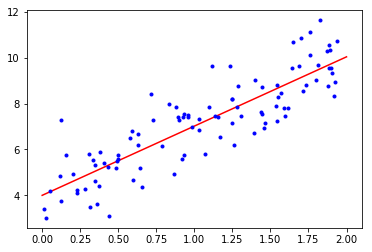

In [32]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.show()

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[4.00104751] [[3.01880386]]


array([[ 4.00104751],
       [10.03865523]])

**What if your data is actually more complex than a simple straight line?**

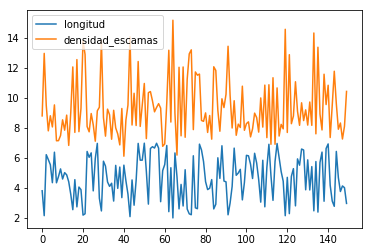

In [59]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/shpotes/ML-biocomp/master/notebooks/lectures/data/trilotropicos.csv')
df.plot()

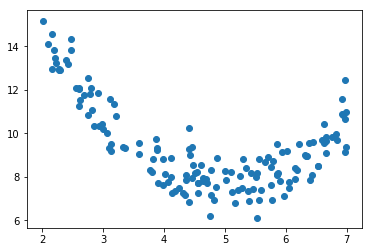

In [60]:
plt.scatter(df.iloc[:,0], df.iloc[:,1])

In [62]:
X = np.c_[np.ones(df.shape[0]), df.values[:,0]]
y = df.values[:,1]

th_best = np.linalg.inv(X.T @ X) @ X.T @ y
th_best

array([12.68999806, -0.71805908])

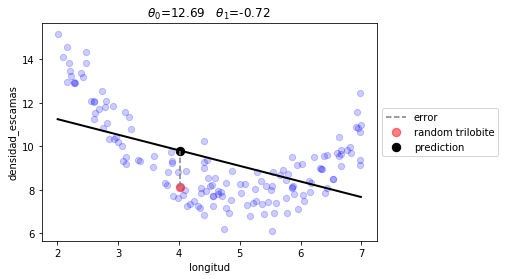

In [77]:
from Utils.lect2 import plot_model

plot_model(df, th_best, lambda th, x: th[0] + th[1] * x)

### Polynomial Regression
you can actually use a linear model to fit nonlinear data. A simple way to do this is to
add powers of each feature as new features, then train a linear model on this extended
set of features.

In [104]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly_features.fit_transform(X[:,1].reshape(150,1))

print(X[0,1])
print(X_poly[0])

3.8171950316710164
[ 3.81719503 14.57097791]


In [110]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

th_best = [lin_reg.intercept_] + lin_reg.coef_.tolist()

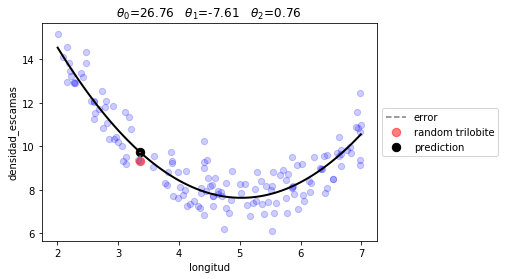

In [112]:
plot_model(df, th_best, lambda th, x: th[0] + th[1] * x + th[2] * x**2)

### Logistic regression

Classification with "linear" regression

$$ \hat{p} = \sigma(\theta^T \cdot\textbf{x}) $$

Model prediction

$$ \hat{y} = \begin{cases} 0\text{ if } \hat{p} < 0.5, \\
1\text{ otherwise.} \end{cases} $$

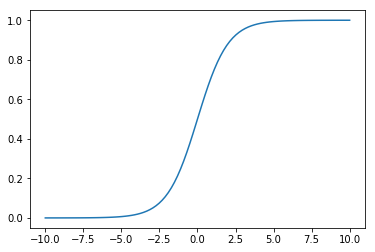

In [116]:
def sigma(t): return 1/(1 + np.exp(-t))

t = np.linspace(-10, 10, 100)
plt.plot(t, sigma(t))

#### Cost?
$$ c(\theta) = \begin{cases} -\log{(\hat{p})} & \text{if } y = 1 \\ 
-\log{(1 - \hat{p})} & \text{if } y = 0 \end{cases} $$ 

In [120]:
for i in range(2, -5, -1):
    print('log(10^{})'.format(i), -np.log(10**i))

log(10^2) -4.605170185988092
log(10^1) -2.302585092994046
log(10^0) -0.0
log(10^-1) 2.3025850929940455
log(10^-2) 4.605170185988091
log(10^-3) 6.907755278982137
log(10^-4) 9.210340371976182
